In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from env import get_db_url
import warnings
warnings.filterwarnings("ignore")

file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

Go through the lesson commenting code, adding docstrings, and adding markdown to support what is happening.

#
# Acquire the data

In [5]:
query = """
select *
from logs;
"""
url = get_db_url('curriculum_logs')

In [6]:
# Bring in the data
df = pd.read_sql(query, url)

In [7]:
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [9]:
df.to_csv('web_traffic.csv')

#
# Prepare the data

In [10]:
# Drop the time column
df = df.drop(columns='time')

In [11]:
# Rename columns to match the curriculum
df = df.rename(columns={'path': 'endpoint', 'ip':'source_ip'})

In [12]:
# Set the date column as the datetime index
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

# Create a series that displays the number of times a page was accessed each day
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

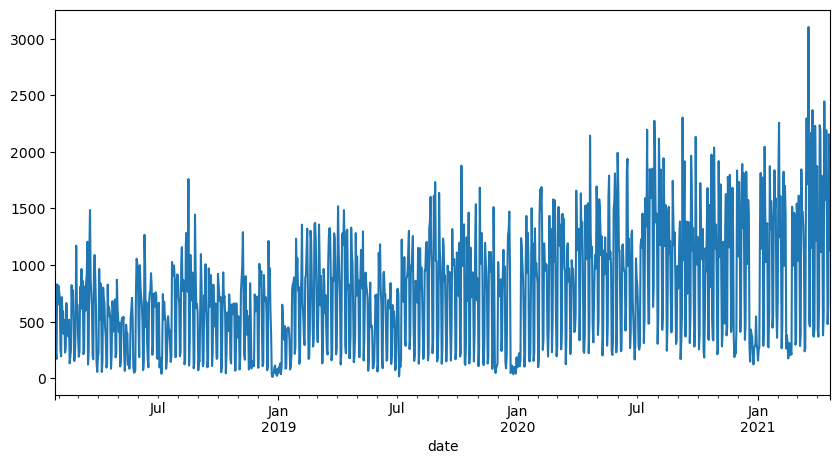

In [15]:
# Plot the page traffic
plt.figure(figsize=(10,5))
pages.plot();

#
# Plot exponential moving averages

In [17]:
# Calculate 7 day EMA and assign to a series
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

In [18]:
# Calculate 14 day EMA and assign to a series
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()

date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: endpoint, dtype: float64

In [20]:
# Calculate 30 day EMA and assign to a series
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [22]:
# Calculate 90 day EMA and assign to a series
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: endpoint, dtype: float64

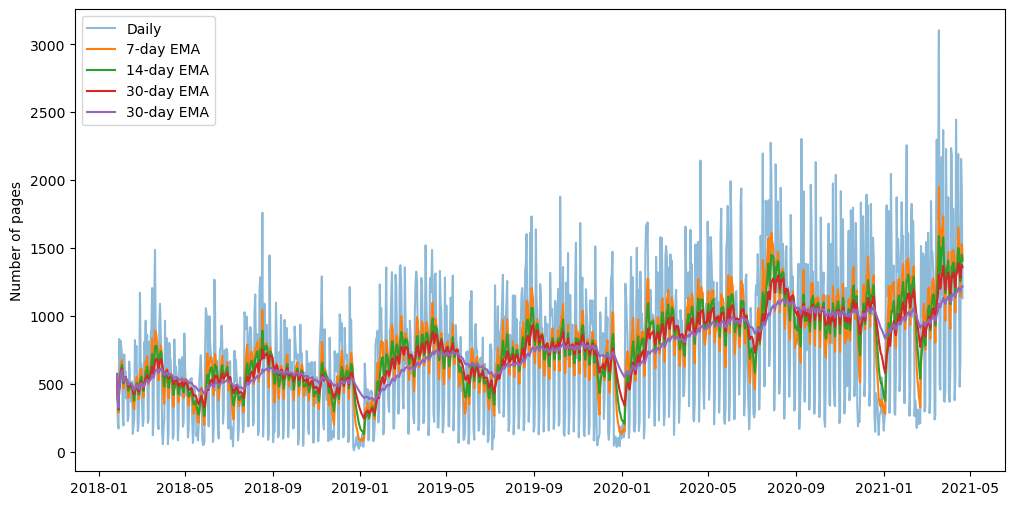

In [23]:
# Plot all of the EMA's over the daily traffic data
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)
ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

#
# Bollinger Bands

In [24]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [25]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [ ]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

In [26]:
# Display the upper bound
ub

date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
                 ...     
2021-04-17    3545.216722
2021-04-18    3486.733695
2021-04-19    3569.147958
2021-04-20    3579.231798
2021-04-21    3499.094360
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [27]:
# Display the lower bound
lb

date
2018-01-26           NaN
2018-01-27   -330.191557
2018-01-28   -326.494835
2018-01-29   -492.401124
2018-01-30   -352.070116
                 ...    
2021-04-17   -894.858492
2021-04-18   -922.334061
2021-04-19   -891.999913
2021-04-20   -825.770723
2021-04-21   -777.340451
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [28]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [29]:
# Concatenate the page traffic with the EMA and bollinger band information
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


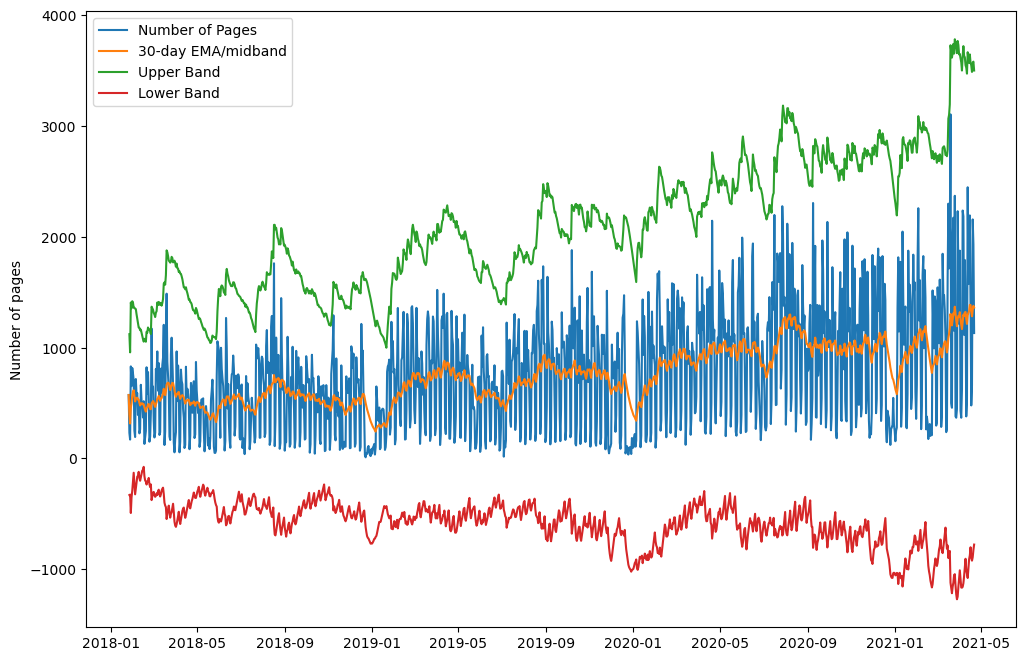

In [30]:
# Plot the Bollinger Band's over the data

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


# Compute %b

In [31]:
# Get the last measure of gb
last_measure = my_df.iloc[-1].pages
last_measure

1131.0

In [32]:
# Get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb

-777.3404511353885

In [35]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub

3499.0943598250406

In [36]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.45


In [37]:
# Compute the %b for each data point and assgn to a series
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


In [38]:
# Display all of the detected anomales in the data
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,


## This method found no anomalies. Adjusting the standard deviations the Bollinger Bands are set to should give us enough sensitivity to detect some outliers

# Define functions that accomplish anomaly detection with this method

In [ ]:
################ ACQUIRE FUNCTION ###############

def acquire(file_name, column_names):
    """
    Takes in a filename where the web traffic data s stored and a list of column names, returns a dataframe
    """
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])


################ PREP FUNCTION ###############

def prep(df, user):
    """
    Takes in a dataframe and a user_id then prepares the dataframe by:
    
    1. Finding just the requests made by the specified user and storing them in 'df'
    2. Assigning the date column as the datetime index
    3. Creating the pages series which holds traffic information per endpoint, per day
    """
    # Find the specified users requests
    df = df[df.user_id == user]
    
    # Set the datetime index
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    
    # Assign web traffic data to a series
    pages = df['endpoint'].resample('d').count()
    
    return pages


################ COMPUTE PCT B FUNCTION ###############

def compute_pct_b(pages, span, weight, user):
    """
    Takes in the pages, span, weight, and user arguments. Computes the EMA and Bollinger Bands
    and stores them in a column. Computes percent b for each data point and assigns the info
    to a new column in the dataframe called 'pct_b'. Returns the dataframe with the bollinger bands,
    and percent b's attached.
    """
    # Compute the EMA
    midband = pages.ewm(span=span).mean()
    
    # Compute the standard deviation of web traffic from the EMA over the specified span
    stdev = pages.ewm(span=span).std()
    
    # Compute the Bollinger Bands and assign them to series
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Concat the bands into a single dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Concat the pages series with the new EMA and bollinger bands info
    my_df = pd.concat([pages, midband, bb], axis=1)
    
    # Rename the columns in the dataframe
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    
    # Compute the percent b's and assign to a new column in the df named 'pct_b'
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    
    # Assign a new column marking all of this data with the specified user_id
    my_df['user_id'] = user
    
    return my_df


################ PLT BANDS FUNCTION ###############

def plt_bands(my_df, user):
    """
    Plots the Bollinger Bands over the web traffic data
    """
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

################ FIND ANOMALIES FUNCTION ###############  

def find_anomalies(df, user, span, weight):
    """
    Takes in a specified dataframe, user, span and weight and uses them to identify
    anomalous web traffic from the specified user and presents it in the output dataframe
    """
    # Computes the web traffic data for the user and assigns it to a seris
    pages = prep(df, user)
    
    # Computes the Bollinger Bands and percent b's and stores the information in a dataframe with the web traffic data
    my_df = compute_pct_b(pages, span, weight, user)
    
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]
